In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
def make_data(N, f=0.3, rseed=1):
    rand = np.random.RandomState(rseed)
    x = rand.randn(N)
    x[int(f * N):] += 5
    return x

In [3]:
x = make_data(1000)

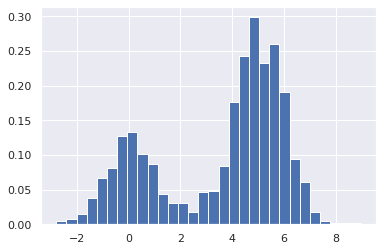

In [4]:
hist = plt.hist(x, bins=30, density=True)

In [5]:
density, bins, patches = hist
widths = bins[1:] - bins[:-1]
(density * widths).sum()

1.0

In [6]:
x = make_data(20)
bins = np.linspace(-5, 10, 10)

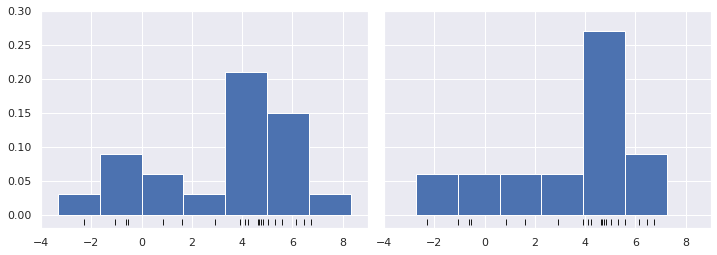

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4),
                      sharex=True, sharey=True,
                      subplot_kw={'xlim':(-4, 9),
                                 'ylim':(-0.02, 0.3)})
fig.subplots_adjust(wspace=0.05)
for i, offset in enumerate([0.0, 0.6]):
    ax[i].hist(x, bins=bins + offset, density=True)
    ax[i].plot(x, np.full_like(x, -0.01), '|k',
               markeredgewidth=1)

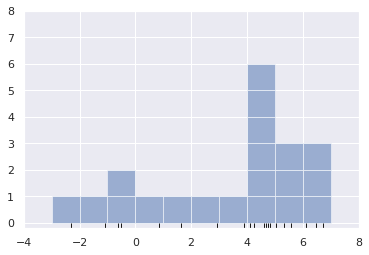

In [9]:
fig, ax = plt.subplots()
bins = np.arange(-3, 8)
ax.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

for count, edge in zip(*np.histogram(x, bins)):
    for i in range(count):
        ax.add_patch(plt.Rectangle((edge, i), 1, 1, alpha=0.5))
    ax.set_xlim(-4, 8)
    ax.set_ylim(-0.2, 8)

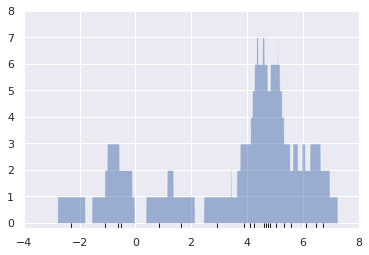

In [15]:
x_d = np.linspace(-4, 8, 2000)
density = sum((abs(xi - x_d) < 0.5) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 8]);

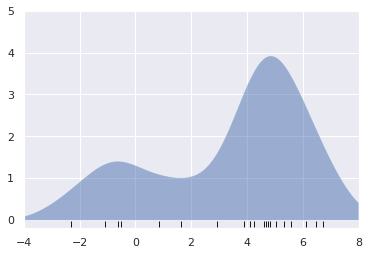

In [18]:
from scipy.stats import norm

x_d = np.linspace(-4, 8, 1000)
density = sum(norm(xi).pdf(x_d) for xi in x)

plt.fill_between(x_d, density, alpha=0.5)
plt.plot(x, np.full_like(x, -0.1), '|k', markeredgewidth=1)

plt.axis([-4, 8, -0.2, 5]);

(-0.02, 0.22)

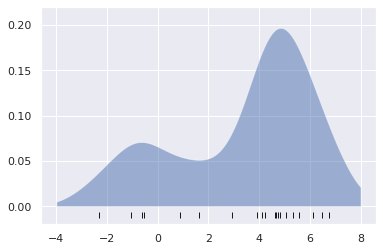

In [19]:
from sklearn.neighbors import KernelDensity

kde = KernelDensity(bandwidth=1.0, kernel='gaussian')
kde.fit(x[:, None])

logprob = kde.score_samples(x_d[:, None])

plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
plt.plot(x, np.full_like(x, -0.01), '|k', markeredgewidth=1)
plt.ylim(-0.02, 0.22)

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import LeaveOneOut

bandwidths = 10 ** np.linspace(-1, 1, 100)
grid = GridSearchCV(KernelDensity(kernel='gaussian'),
                   {'bandwidth': bandwidths},
                   cv=LeaveOneOut())
grid.fit(x[:, None]);

In [24]:
grid.best_params_

{'bandwidth': 1.1233240329780276}

In [25]:
from sklearn.datasets import fetch_species_distributions

data = fetch_species_distributions()

latlon = np.vstack([data.train['dd lat'],
                   data.train['dd long']]).T
species = np.array([d.decode('ascii').startswith('micro')
                   for d in data.train['species']], dtype='int')

/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if __name__ == '__main__':
/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  del sys.path[0]


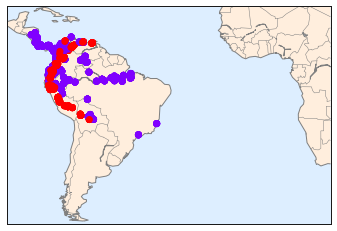

In [29]:
from mpl_toolkits.basemap import Basemap
from sklearn.datasets.species_distributions import construct_grids
from inspect import cleandoc as dedent

xgrid, ygrid = construct_grids(data)

m = Basemap(projection='cyl', resolution='c',
           llcrnrlat=ygrid.min(), urcrnrlat=ygrid.max(),
           llcrnrlon=xgrid.min(), urcrnrlon=ygrid.max())
m.drawmapboundary(fill_color='#DDEEFF')
m.fillcontinents(color='#FFEEDD')
m.drawcoastlines(color='gray', zorder=2)
m.drawcountries(color='gray', zorder=2)

m.scatter(latlon[:, 1], latlon[:, 0], zorder=3,
         c=species, cmap='rainbow', latlon=True);

/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
/home/arti/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


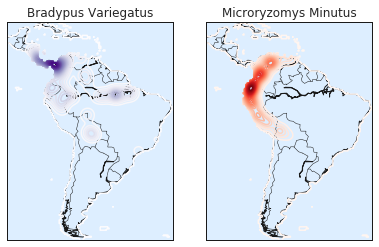

In [31]:
x, y = np.meshgrid(xgrid[::5], ygrid[::5][::-1])
land_reference = data.coverages[6][::5, ::5]
land_mask = (land_reference > -9999).ravel()
xy = np.vstack([y.ravel(), x.ravel()]).T
xy = np.radians(xy[land_mask])

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
species_names = ['Bradypus Variegatus', 'Microryzomys Minutus']
cmaps = ['Purples', 'Reds']

for i, axi in enumerate(ax):
    axi.set_title(species_names[i])
    m = Basemap(projection='cyl', llcrnrlat=y.min(),
               urcrnrlat=y.max(), llcrnrlon=x.min(),
               urcrnrlon=x.max(), resolution='c', ax=axi)
    m.drawmapboundary(fill_color='#DDEEFF')
    m.drawcoastlines()
    m.drawcountries()
    
    kde = KernelDensity(bandwidth=0.03, metric='haversine')
    kde.fit(np.radians(latlon[species == i]))
    
    z = np.full(land_mask.shape[0], -9999.0)
    z[land_mask] = np.exp(kde.score_samples(xy))
    z = z.reshape(x.shape)
    
    levels = np.linspace(0, z.max(), 25)
    axi.contour(x, y, z, levels=levels, cmap=cmaps[i])